<a href="https://colab.research.google.com/github/cjs220/active_learning_ratio_estimation/blob/master/examples/active_learning_mixtures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment the code below to temporarily install active_learning_ratio_estimation from source
# if you do not do this, unless you already have it installed in this environment, this notebook will not run

import os, sys, tempfile, shutil
original_dir = os.getcwd()
REPO_NAME = 'active_learning_ratio_estimation'
BRANCH = 'master'
tempdir = tempfile.gettempdir()
os.chdir(tempdir)
if os.path.exists(REPO_NAME):
  print('Removing repo')
  shutil.rmtree(REPO_NAME)
print('Cloning repo')
os.system(f'git clone --single-branch --branch {BRANCH} https://github.com/cjs220/{REPO_NAME}.git')
sys.path.insert(0, os.path.join(tempdir, REPO_NAME))
os.chdir(original_dir)

Cloning repo


In [0]:
# matplotlib setup
import matplotlib.pyplot as plt

%matplotlib inline

size=24
params = {
    'legend.fontsize': size*0.75,
    'figure.figsize': (10, 5),
    'axes.labelsize': size,
    'axes.titlesize': size,
    'xtick.labelsize': size * 0.75,
    'ytick.labelsize': size * 0.75,
    'font.family': 'sans-serif',
    'axes.titlepad': 12.5
}
plt.rcParams.update(params)

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions


def triple_mixture(gamma):
    mixture_probs = [
        0.5 * (1 - gamma),
        0.5 * (1 - gamma),
        gamma
    ]
    gaussians = [
        tfd.Normal(loc=-2, scale=0.75),
        tfd.Normal(loc=0, scale=2),
        tfd.Normal(loc=1, scale=0.5)
    ]
    dist = tfd.Mixture(
        cat=tfd.Categorical(probs=mixture_probs),
        components=gaussians
    )
    return dist

In [0]:
from active_learning_ratio_estimation.dataset import ParamGrid, ParamIterator, SinglyParameterizedRatioDataset

theta_bounds = (0, 1)
theta_0 = 0.05
num_grid = 101
n_samples_per_theta = int(1e3)
param_grid = ParamGrid(bounds=[theta_bounds], num=num_grid)  # all possible parameter points

theta_1_iterator = ParamGrid(bounds=[theta_bounds], num=3)  # initial parameter points in dataset

# test dataset
n_test_param = 10
test_iterator = ParamIterator([np.random.rand(1) for _ in range(n_test_param)])
test_dataset = SinglyParameterizedRatioDataset.from_simulator(
    simulator_func=triple_mixture,
    theta_0=theta_0,
    theta_1_iterator=test_iterator,
    n_samples_per_theta=n_samples_per_theta,
    include_log_probs=True
)

In [0]:
from active_learning_ratio_estimation.model import FlipoutClassifier, SinglyParameterizedRatioModel

estimator_kwargs = dict(
    n_hidden=(15, 15),
    epochs=5,
    patience=0,
    validation_split=0.1,
    verbose=0,
)

def get_active_learner(acquisition_function):
    estimator = FlipoutClassifier(**estimator_kwargs)
    ratio_model = SinglyParameterizedRatioModel(estimator=estimator)
    
    active_learner = ActiveLearner(
        simulator_func=triple_mixture,
        theta_0=theta_0,
        theta_1_iterator=theta_1_iterator,
        n_samples_per_theta=n_samples_per_theta,
        ratio_model=ratio_model,
        total_param_grid=param_grid,
        test_dataset=None,
        acquisition_function=acquisition_function,
        ucb_kappa=0.0,
        validation_mode=False,
    )
    return active_learner

In [6]:
from active_learning_ratio_estimation.active_learning import ActiveLearner

n_iter = 15


def fit_active_learner(acquisition_function, verbose=False):
    if verbose:
        print(f'\n**** Fitting with {acquisition_function} ****\n'
              f'n_iter={n_iter}, num_grid={num_grid}, '
              f'n_test_param={n_test_param}, n_samples_per_theta={n_samples_per_theta}\n'
              f'estimator_kwargs={estimator_kwargs}')
    active_learner = get_active_learner(acquisition_function)
    active_learner.fit(n_iter, verbose=verbose)
    return active_learner


active_learners = dict()
acquisition_functions = [
    'std_regressor',
    'random'
]

for acquisition_function in acquisition_functions:
    active_learners[acquisition_function] = fit_active_learner(acquisition_function, verbose=True)  


**** Fitting with std_regressor ****
n_iter=15, num_grid=101, n_test_param=10, n_samples_per_theta=1000
estimator_kwargs={'n_hidden': (15, 15), 'epochs': 5, 'patience': 0, 'validation_split': 0.1, 'verbose': 0}
Instructions for updating:
Please use `layer.add_weight` method instead.
Active learning iteration 1/15
Best epoch information: loss=7.61E-01, accuracy=6.11E-01, val_loss=6.96E-01, val_accuracy=7.07E-01
Active learning iteration 2/15
Best epoch information: loss=7.02E-01, accuracy=6.30E-01, val_loss=6.34E-01, val_accuracy=7.25E-01
Active learning iteration 3/15
Best epoch information: loss=6.67E-01, accuracy=6.91E-01, val_loss=5.81E-01, val_accuracy=7.38E-01
Active learning iteration 4/15
Best epoch information: loss=6.44E-01, accuracy=6.99E-01, val_loss=5.28E-01, val_accuracy=7.83E-01
Active learning iteration 5/15
Best epoch information: loss=6.11E-01, accuracy=7.24E-01, val_loss=5.27E-01, val_accuracy=7.57E-01
Active learning iteration 6/15
Best epoch information: loss=6.02E

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Best epoch information: loss=5.95E-01, accuracy=7.12E-01, val_loss=5.10E-01, val_accuracy=7.83E-01
Active learning iteration 8/15
Best epoch information: loss=5.70E-01, accuracy=7.39E-01, val_loss=4.93E-01, val_accuracy=8.00E-01
Active learning iteration 9/15


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Best epoch information: loss=5.74E-01, accuracy=7.48E-01, val_loss=5.13E-01, val_accuracy=7.81E-01
Active learning iteration 10/15
Best epoch information: loss=5.57E-01, accuracy=7.52E-01, val_loss=4.91E-01, val_accuracy=7.83E-01
Active learning iteration 11/15
Best epoch information: loss=5.49E-01, accuracy=7.62E-01, val_loss=4.85E-01, val_accuracy=7.89E-01
Active learning iteration 12/15
Best epoch information: loss=5.56E-01, accuracy=7.47E-01, val_loss=5.07E-01, val_accuracy=7.80E-01
Active learning iteration 13/15


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Best epoch information: loss=5.43E-01, accuracy=7.64E-01, val_loss=4.74E-01, val_accuracy=7.93E-01
Active learning iteration 14/15
Best epoch information: loss=5.41E-01, accuracy=7.49E-01, val_loss=4.71E-01, val_accuracy=8.07E-01
Active learning iteration 15/15
Best epoch information: loss=5.38E-01, accuracy=7.65E-01, val_loss=4.69E-01, val_accuracy=7.96E-01

**** Fitting with random ****
n_iter=15, num_grid=101, n_test_param=10, n_samples_per_theta=1000
estimator_kwargs={'n_hidden': (15, 15), 'epochs': 5, 'patience': 0, 'validation_split': 0.1, 'verbose': 0}
Active learning iteration 1/15
Best epoch information: loss=7.75E-01, accuracy=5.61E-01, val_loss=7.55E-01, val_accuracy=6.08E-01
Active learning iteration 2/15
Best epoch information: loss=7.38E-01, accuracy=5.86E-01, val_loss=6.98E-01, val_accuracy=6.59E-01
Active learning iteration 3/15
Best epoch information: loss=7.33E-01, accuracy=5.89E-01, val_loss=6.93E-01, val_accuracy=6.49E-01
Active learning iteration 4/15
Best epoch in

In [7]:
import pandas as pd

quantities = ('val_loss', 'val_accuracy', 'test_mse')


def collect_results(active_learners):
    index = pd.MultiIndex.from_product([quantities, active_learners.keys()])
    results_df = pd.DataFrame(columns=index)
    
    for acquisition_function, learner in active_learners.items():
        for quantity in quantities[:-1]:
            results_df[quantity, acquisition_function] = learner.train_history[quantity].values
    
        if learner.test_dataset is not None:
            results_df['test_mse', acquisition_function] = learner.test_history.values
    
    return results_df


results_df = collect_results(active_learners)
results_df.head()

val_loss            val_accuracy                test_mse       
  std_regressor    random std_regressor    random std_regressor random
0      0.695536  0.755120      0.707500  0.607500           NaN    NaN
1      0.634378  0.697729      0.725000  0.659000           NaN    NaN
2      0.581434  0.692587      0.737500  0.649167           NaN    NaN
3      0.528008  0.666948      0.782857  0.655000           NaN    NaN
4      0.527200  0.647960      0.757500  0.659375           NaN    NaN

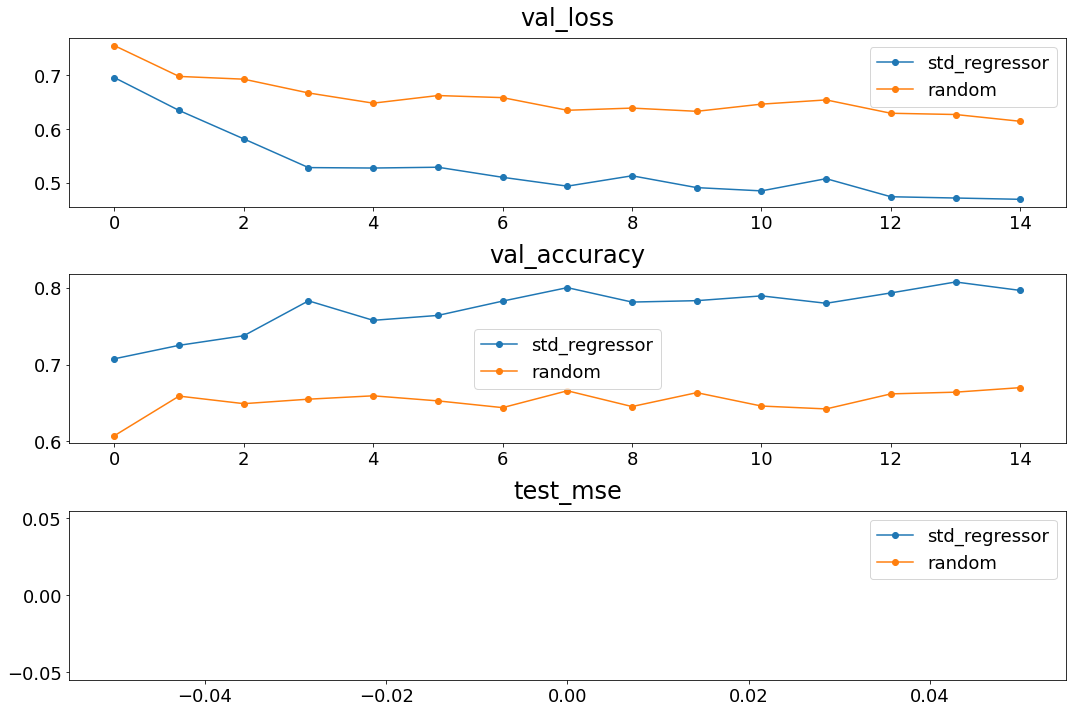

In [8]:
fig, axarr = plt.subplots(len(quantities), figsize=(15, 10))

for i, quantity in enumerate(quantities):
    ax = axarr[i]
    results_df[quantity].plot(ax=ax, marker='o')
    ax.set_title(quantity)

fig.tight_layout()
fig.show()

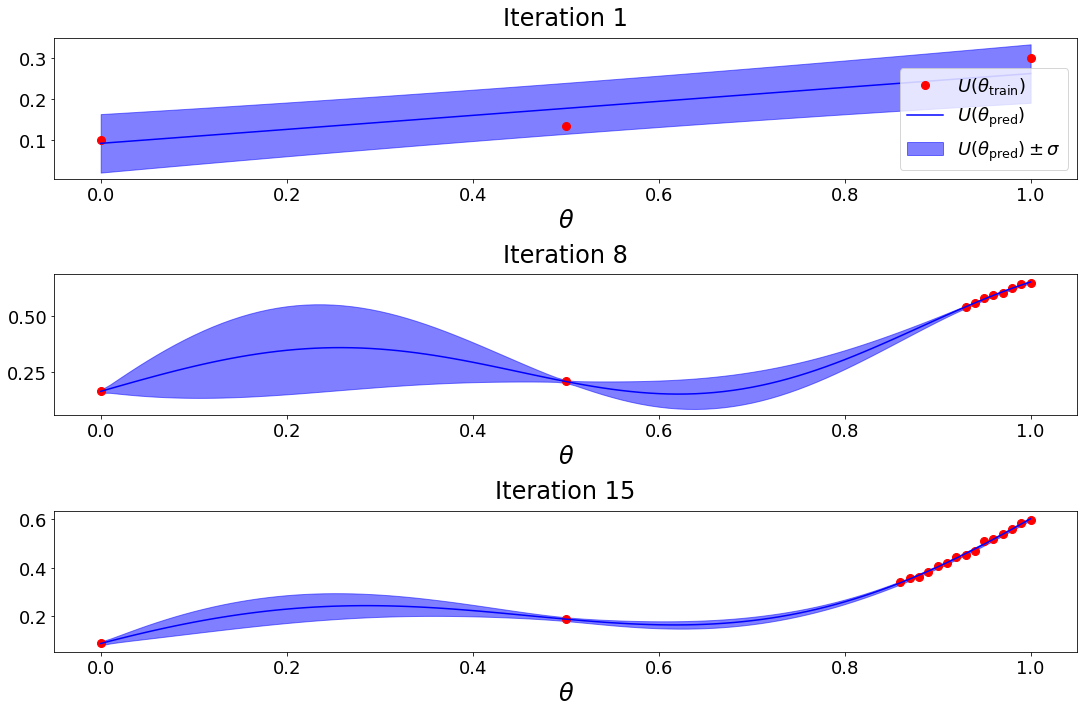

In [9]:
std = active_learners['std_regressor']
f, axarr = plt.subplots(3, figsize=(15, 10))
ax_list = np.ravel(axarr).tolist()

for i, iteration in enumerate([0, n_iter//2, n_iter-1]):
    ax = ax_list[i]
    std.plot_acquisition_history_item(iteration, ax=ax,fig=f)
    ax.set_title(f'Iteration {iteration+1}')

ax_list[0].legend()
f.tight_layout()
f.show()

In [10]:
# Now repeat to get means and standard errors
all_results = [results_df]
n_repeats = 4

for i in range(n_repeats):
    print(f'Repeat {i+1}/{n_repeats}')
    for acquisition_function in acquisition_functions:
        active_learners[acquisition_function] = fit_active_learner(acquisition_function, verbose=False)
    all_results.append(collect_results(active_learners)) 

Repeat 1/4


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Repeat 2/4


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Repeat 3/4


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Repeat 4/4


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


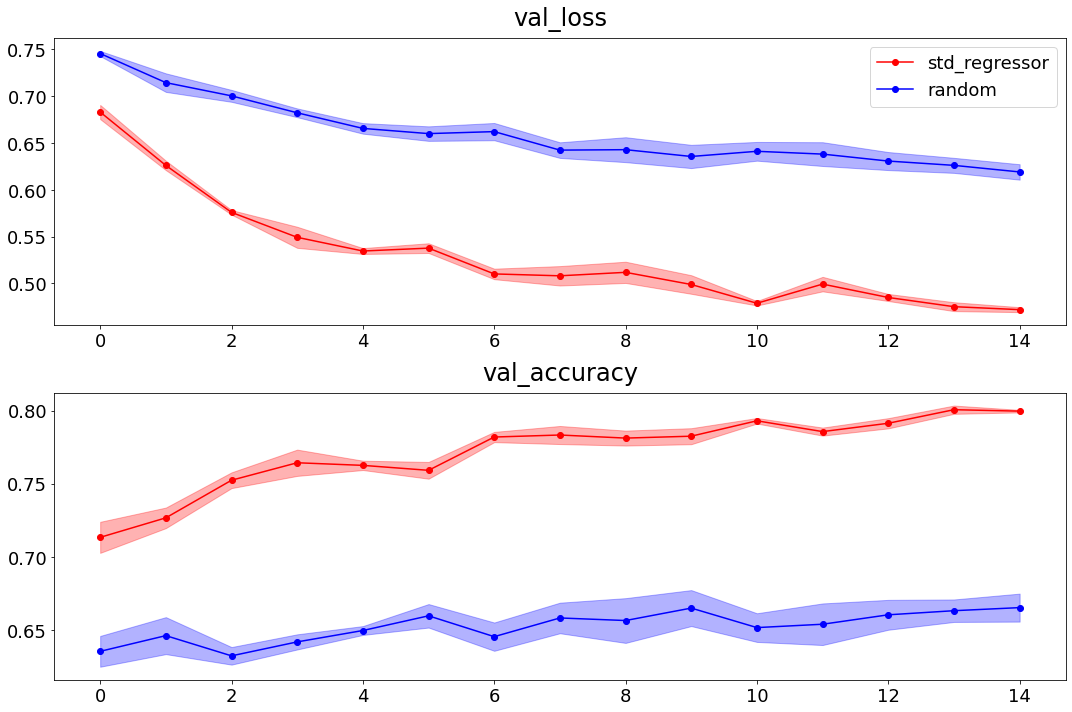

In [14]:
n = len(all_results)
mean = sum(all_results)/n
variance  = sum([(df-mean)**2 for df in all_results])/(n-1)
std = variance**0.5
stderr = std/np.sqrt(n)

fig, axarr = plt.subplots(len(quantities)-1, figsize=(15, 10))
colours = ('r', 'b')

for i, quantity in enumerate(quantities):
    ax = axarr[i]
    for j, af in enumerate(acquisition_functions):
        _mean = mean[quantity, af].values
        _stderr = stderr[quantity, af].values
        mean[quantity, af].plot(ax=ax, color=colours[j], marker='o')
        ax.fill_between(
            x = mean.index.values,
            y1 = _mean + _stderr,
            y2 = _mean - _stderr,
            alpha=0.3,
            color=colours[j]
        )
    ax.set_title(quantity)
    if i == 1:
        break

axarr[0].legend(acquisition_functions)
fig.tight_layout()
fig.show()